<center><h2>ALTeGraD 2023<br>Lab Session 3: Transfer learning for NLP</h2> 24 / 10 / 2023<br> Dr. G. Shang, H. Abdine<br><br>


<b>Student name:</b> [Basile Terver]

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 31, 2023 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import inspect

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid,dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(nhid,nhead,dim_feedforward=nhid,dropout=dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers,nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)#fill me
        output = self.transformer_encoder(src, src_mask) #fill me
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(in_features=nhid,out_features=nclasses)#fill me
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout) #fill me
        self.classifier = ClassificationHead(nhid, nclasses) #fill me

    def forward(self, src, src_mask):
        # base model
        x = self.base(src,src_mask) #fill me
        # classifier model
        output =self.classifier(x) #fill me
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

for name, param in model.named_parameters():
  if param.requires_grad:
    print('number of parameters of',name,'is' ,param.numel())

print('base model trainable weights=',count_parameters(model.base))
print('classifier trainable weights=',count_parameters(model.classifier))

#print(inspect.getmembers(model))

print(out.shape) # is it the right shape?

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


number of parameters of base.encoder.weight is 20000
number of parameters of base.transformer_encoder.layers.0.self_attn.in_proj_weight is 120000
number of parameters of base.transformer_encoder.layers.0.self_attn.in_proj_bias is 600
number of parameters of base.transformer_encoder.layers.0.self_attn.out_proj.weight is 40000
number of parameters of base.transformer_encoder.layers.0.self_attn.out_proj.bias is 200
number of parameters of base.transformer_encoder.layers.0.linear1.weight is 40000
number of parameters of base.transformer_encoder.layers.0.linear1.bias is 200
number of parameters of base.transformer_encoder.layers.0.linear2.weight is 40000
number of parameters of base.transformer_encoder.layers.0.linear2.bias is 200
number of parameters of base.transformer_encoder.layers.0.norm1.weight is 200
number of parameters of base.transformer_encoder.layers.0.norm1.bias is 200
number of parameters of base.transformer_encoder.layers.0.norm2.weight is 200
number of parameters of base.tra

## Vocabulary and Tokenization

In [5]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2023-10-30 15:13:33--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.04s   

2023-10-30 15:13:33 (15.2 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [6]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx+4 #fill me

ind2token = {} #fill me
for token,ind in token2ind.items():
    ind2token[ind]=token
#ind2token = {v: k for k, v in token2ind.items()}

print(ind2token[1111])

▁trop


### Data Loader


In [7]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence =[self.token2ind['<sos>']]+ [self.token2ind[token] if token in token2ind.keys() else self.token2ind['<oov>'] for token in sequence ]#fill me (constract the input sequence using token2ind, sequence and special tokens)
        #source_sequence = [token2ind.get('<sos>')] + [token2ind.get(token) if token2ind.get(token) != None else 3 for token in sequence]
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [8]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1]#fill me
        output = output.view(-1, output.shape[-1])
        target = data[1] #fill me
        target = target.to(device)
        loss = criterion(output,target) #fill me, Cross entropy check next cells
        #fill me step 3
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        #fill me step 4
        optimizer.step()
        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [9]:
ntokens = len(token2ind) #fill me # the size of vocabulary
print('ntokens=',ntokens)
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

print('base model trainable weights=',count_parameters(model.base))
print('classifier trainable weights=',count_parameters(model.classifier))

ntokens= 50001
base model trainable weights= 10968200
classifier trainable weights= 10050201


In [10]:
import sympy
from sympy import symbols, Eq, solve, sympify
from IPython.display import display, Markdown
from prettytable import PrettyTable

#Done with the help of ChatGPT
def parameters_table(model):
  table=PrettyTable(["Module","Number trainable weights"])
  total_nb_params=0
  for name,param in model.named_parameters():
    if param.requires_grad:
      nb_params=param.numel()
      table.add_row([name,nb_params])
      total_nb_params+=nb_params
  print(table)
  print(f"Total number trainable params:",total_nb_params)

parameters_table(model)

+-------------------------------------------------------------+--------------------------+
|                            Module                           | Number trainable weights |
+-------------------------------------------------------------+--------------------------+
|                     base.encoder.weight                     |         10000200         |
|  base.transformer_encoder.layers.0.self_attn.in_proj_weight |          120000          |
|   base.transformer_encoder.layers.0.self_attn.in_proj_bias  |           600            |
| base.transformer_encoder.layers.0.self_attn.out_proj.weight |          40000           |
|  base.transformer_encoder.layers.0.self_attn.out_proj.bias  |           200            |
|       base.transformer_encoder.layers.0.linear1.weight      |          40000           |
|        base.transformer_encoder.layers.0.linear1.bias       |           200            |
|       base.transformer_encoder.layers.0.linear2.weight      |          40000           |

In [11]:
# optimization parameters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2023-10-30 15:13:34--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.07s   

2023-10-30 15:13:34 (138 MB/s) - ‘pretraining_subset.txt’ saved [10146460/10146460]



In [13]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task='language_modeling', # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.30129 | ppl 1482.206
| epoch   1 |  1000/ 3125 steps | loss 6.47896 | ppl  651.290
| epoch   1 |  1500/ 3125 steps | loss 6.21225 | ppl  498.821
| epoch   1 |  2000/ 3125 steps | loss 6.04618 | ppl  422.497
| epoch   1 |  2500/ 3125 steps | loss 5.92541 | ppl  374.430
| epoch   1 |  3000/ 3125 steps | loss 5.82820 | ppl  339.745
| epoch   2 |   500/ 3125 steps | loss 5.52108 | ppl  249.904
| epoch   2 |  1000/ 3125 steps | loss 5.48774 | ppl  241.709
| epoch   2 |  1500/ 3125 steps | loss 5.44714 | ppl  232.094
| epoch   2 |  2000/ 3125 steps | loss 5.41258 | ppl  224.210
| epoch   2 |  2500/ 3125 steps | loss 5.37499 | ppl  215.938
| epoch   2 |  3000/ 3125 steps | loss 5.36866 | ppl  214.574


## Text Generation


In [14]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2023-10-30 15:18:26--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt’

pretrained_model_4l 100%[===================>]  84.01M   349MB/s    in 0.2s    

2023-10-30 15:18:26 (349 MB/s) - ‘pretrained_model_4layers.pt’ saved [88093955/88093955]



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [15]:
!pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00
--2023-10-30 15:18:32--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-10-30 15:18:33 (24.7 MB/s) - ‘sentencepiece.french.model’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [16]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    #print('sent_pieces=', sent_pieces)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    #print('out shape=',out.shape)
    next_token_ind = out.argmax(-1) #fill me
    #print('next_token_ind argmax',next_token_ind)
    next_token_ind=next_token_ind[-1,0]
    #print('last next_token_ind=',next_token_ind)
    next_token_ind=int(next_token_ind)
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    # to be implemented
    sent_pieces = s.encode_as_pieces(sent)
    completed_sent = sent
    completed_sent_pieces = sent_pieces
    while len(completed_sent_pieces)<max_len:
      next_token_ind=infer_next_token(completed_sent)[0]
      #print('next_token_ind=',next_token_ind)
      next_token=ind2token.get(next_token_ind)
      #print('next_token=',next_token)
      completed_sent_pieces.append(next_token)
      completed_sent = s.decode_pieces(completed_sent_pieces)
      if next_token_ind==2:
        break
    return completed_sent



In [17]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les gens qui ont été très accueillants et sympathiques.<eos>'

### Supervised task

In [18]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2023-10-30 15:18:33--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.04s   

2023-10-30 15:18:33 (33.3 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2023-10-30 15:18:33--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent,

In [19]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    #to be implemented
    N=len(data_loader.dataset)
    #print('N=',N)
    batch_size=data_loader.batch_size
    #print('batch_size=',batch_size)
    outputs=torch.zeros(N)#.to(device)
    targets=torch.zeros(N)#.to(device)
    for idx, data in enumerate(data_loader):
      src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
        device)
      input = data[0].to(device)
      output = model(input, src_mask)
      #if data_loader.task == 'classification':
      output = output[-1]
      #print('output[-1] shape=',output.shape)
      #output = output.view(-1, output.shape[-1])
      #print('output reshaped shape=',output.shape)
      #take most probable of the two classes
      #print('output.argmax(axis=1) shape=',output.argmax(axis=1).shape)
      #print('idx=',idx)
      outputs[idx*batch_size: (idx+1)*batch_size] = output.argmax(axis=1)
      #print('output post argmax shape=',output.shape)
      targets[idx*batch_size: (idx+1)*batch_size] = data[1]
      #print('target shape=',target.shape)
      #target = target.to(device)


    #print('targets shape=',targets.shape)
    #print('outputs shape=',outputs.shape)
    return torch.sum(targets==outputs)/N

In [20]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [21]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.75491 | ppl    2.127
| epoch   1 |   100/  200 steps | loss 0.74181 | ppl    2.100
| epoch   1 |   150/  200 steps | loss 0.73361 | ppl    2.083
| epoch   2 |    50/  200 steps | loss 0.64499 | ppl    1.906
| epoch   2 |   100/  200 steps | loss 0.63780 | ppl    1.892
| epoch   2 |   150/  200 steps | loss 0.59072 | ppl    1.805
| epoch   3 |    50/  200 steps | loss 0.46394 | ppl    1.590
| epoch   3 |   100/  200 steps | loss 0.36906 | ppl    1.446
| epoch   3 |   150/  200 steps | loss 0.40134 | ppl    1.494
| epoch   4 |    50/  200 steps | loss 0.23960 | ppl    1.271
| epoch   4 |   100/  200 steps | loss 0.12400 | ppl    1.132
| epoch   4 |   150/  200 steps | loss 0.11196 | ppl    1.118
| epoch   5 |    50/  200 steps | loss 0.01505 | ppl    1.015
| epoch   5 |   100/  200 steps | loss 0.03836 | ppl    1.039
| epoch   5 |   150/  200 steps | loss 0.04676 | ppl    1.048
| epoch   6 |    50/  200 steps | loss

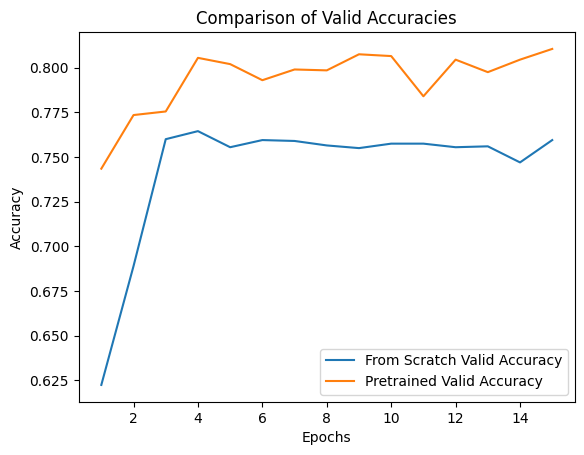

In [22]:
#Visualize the accuracy
import matplotlib.pyplot as plt

epochs = list(range(1, len(from_scratch_valid_acc) + 1))

plt.plot(epochs, from_scratch_valid_acc, label='From Scratch Valid Accuracy')
plt.plot(epochs, pretrained_valid_acc, label='Pretrained Valid Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Valid Accuracies')
plt.legend()
plt.show()
